In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import os
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

In [3]:
dep_path = 'data/condition'
nondep_path = 'data/control'
score_file_path = 'data/scores.csv'

dep_filename = sorted(os.listdir(dep_path))
nondep_filename = sorted(os.listdir(nondep_path))


In [4]:
def read_files(path):
    return pd.read_csv(path)

scores = read_files(score_file_path)

dep_files = []
nondep_files = []

for i in dep_filename:
    dep_files.append({"name":i.split('.')[0],"df":read_files(f"{dep_path}/{i}")})
    
for i in nondep_filename:
    nondep_files.append({"name":i.split('.')[0],"df":read_files(f"{nondep_path}/{i}")})

In [8]:
dep_files[0]["df"]
dep_files[0]["name"]

'condition_1'

In [10]:
from scipy import optimize

def get_summary_df(df):
    summary_df= df.groupby('time', as_index = False)['activity'].mean()
    return summary_df

def get_ma_df(df, window_length):
    smoothed_df = pd.DataFrame(columns=['activity'])
    smoothed_df['ma'] = df['activity'].rolling(window_length).mean()
    return smoothed_df

def get_savgol_df(df, window_length, polyorder):
    smoothed_df = pd.DataFrame(columns=['activity'])
    smoothed_df['savgol'] = df.apply(lambda x: savgol_filter(x, window_length ,polyorder))
    return smoothed_df

def get_guassian_df(df):
    smoothed_df = pd.DataFrame(columns=['time','activity'])
    xdata = np.array([i for i in range(len(df['time']))])/ 100.0
    ydata = df['activity'].to_numpy()
#     def func(x, a0, b0, c0, a1, b1, c1):
#         return a0*np.exp(-(x-b0)**2/(2*c0**2)) + a1*np.exp(-(x-b1)**2/(2*c1**2))
    
    def func(x, a0, b0, c0, a1, b1, c1, a2, b2, c2):
        return a0*np.exp(-(x-b0)**2/(2*c0**2)) + a1*np.exp(-(x-b1)**2/(2*c1**2))+ a2*np.exp(-(x-b2)**2/(2*c2**2))

    params, params_covariance = optimize.curve_fit(func, xdata, ydata, maxfev=1000000)
    modelPredictions = func(xdata, *params)
    smoothed_df['time'] = df['time']
    smoothed_df['modelPred_activity'] = modelPredictions
    return smoothed_df

In [6]:
def shift_time(df, num):
    shifted_df = pd.DataFrame(columns=['time','activity'])

    shifted_df['activity'] = np.roll(df['activity'],num)
    shifted_df['time'] = np.roll(df['time'],num)
    return shifted_df

In [7]:
def generate(files):
    for i, condition in enumerate(files):
        df = condition["df"]
        df['date'] = pd.to_datetime(df['timestamp'])
        df['time'] = df['date'].dt.strftime('%H:%M:%S')

        temp = df.sort_values(by=['time'])
        preprocessed_df=get_summary_df(temp)
        condition["preprocessed_df"]=preprocessed_df
        condition["preprocessed_df_shifted"]=shift_time(preprocessed_df, -240)

        condition["guassian"]=get_guassian_df(condition["preprocessed_df"])     
        condition["guassian_shifted"]=get_guassian_df(condition["preprocessed_df_shifted"])
generate(nondep_files)
generate(dep_files)
    #plot
#     ax = condition["preprocessed_df"].plot(figsize=(10,5))
#     condition["preprocessed_df_shifted"].plot(ax=ax)
#     condition["sin"].plot(ax=ax)
#     condition["sin_shifted"].plot(ax=ax)
#     ax.legend(["preprocessed_df", "preprocessed_df_shifted","sin","sin_shifted"])

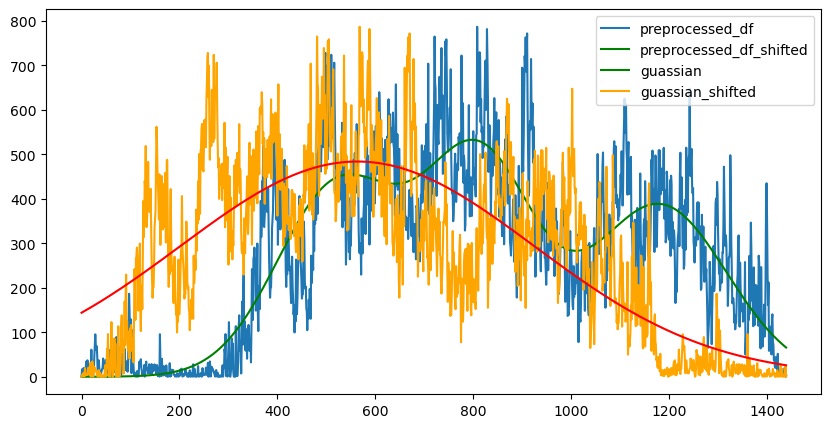

In [30]:
ax = nondep_files[1]["preprocessed_df"].plot(figsize=(10,5))
nondep_files[1]["guassian"].plot(ax=ax,color='green')
nondep_files[1]["preprocessed_df_shifted"].plot(ax=ax,color='orange')
nondep_files[1]["guassian_shifted"].plot(ax=ax,color='red')
ax.legend(["preprocessed_df", "preprocessed_df_shifted","guassian","guassian_shifted"])

<Figure size 700x350 with 0 Axes>

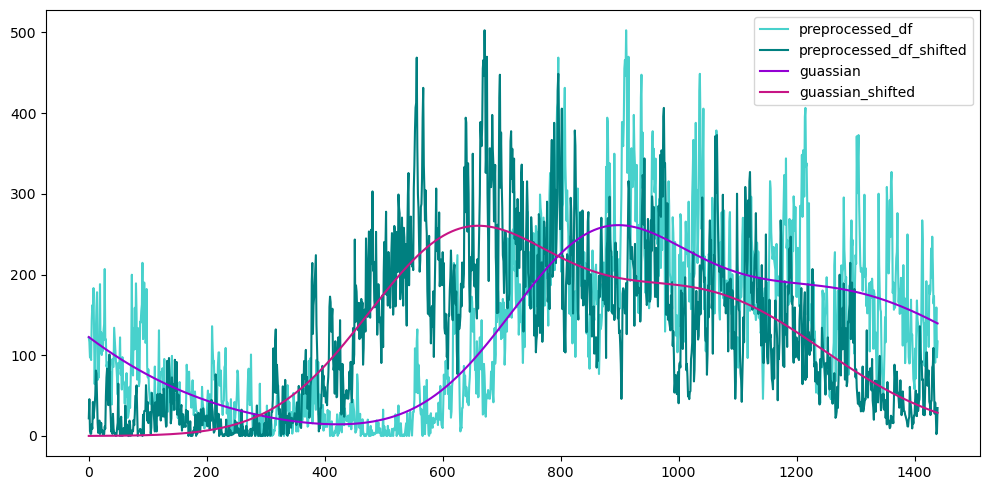

In [55]:
i=2
fig = plt.figure()
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

ax = dep_files[i]["preprocessed_df"].plot(figsize=(10,5),color='mediumturquoise')
# mediumaquamarine mediumturquoise
dep_files[i]["preprocessed_df_shifted"].plot(ax=ax,color='teal')

dep_files[i]["guassian"].plot(ax=ax,color='darkviolet')
dep_files[i]["guassian_shifted"].plot(ax=ax,color='mediumvioletred')


ax.legend(["preprocessed_df", "preprocessed_df_shifted","guassian","guassian_shifted"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('mediumturquoise')
leg.legendHandles[1].set_color('teal')
leg.legendHandles[2].set_color('darkviolet')
leg.legendHandles[3].set_color('mediumvioletred')
plt.show()

<Figure size 700x350 with 0 Axes>

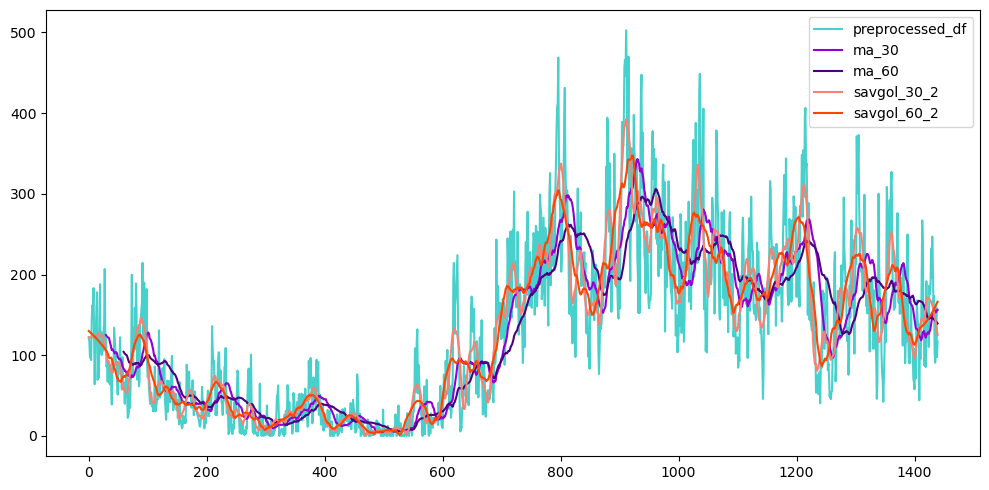

In [82]:
i=2
fig = plt.figure()
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

ax = dep_files[i]["preprocessed_df"].plot(figsize=(10,5),color='mediumturquoise')

get_ma_df(dep_files[i]["preprocessed_df"], 30).plot(ax=ax,color='darkviolet')
get_ma_df(dep_files[i]["preprocessed_df"], 60).plot(ax=ax,color='indigo')

get_savgol_df(dep_files[i]["preprocessed_df"], 30, 2).plot(ax=ax,color='salmon')
get_savgol_df(dep_files[i]["preprocessed_df"], 60, 2).plot(ax=ax,color='orangered')


ax.legend(["preprocessed_df", "ma_30","ma_60","savgol_30_2","savgol_60_2"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('mediumturquoise')
leg.legendHandles[1].set_color('darkviolet')
leg.legendHandles[2].set_color('indigo')
leg.legendHandles[3].set_color('salmon')
leg.legendHandles[4].set_color('orangered')
plt.show()

In [11]:
import json
 
def json_output(files, typename):
    data = {
    "type": typename,
    "files": []
    }
    for i in files:
        a = i["guassian"]["modelPred_activity"].tolist()
        x = {
          "file": i["name"],
          "activity_level": a
        }
        data["files"].append(x)
    with open(f"{typename}.json", "w") as outfile:
        json.dump(data, outfile)
    return True

# json_output(nondep_files, "non-depressed")
# json_output(dep_files, "depressed")

In [11]:
with open("depressed.json", "r") as openfile:
    json_object = json.load(openfile)
json_object

{'type': 'depressed',
 'files': [{'file': 'condition_1',
   'activity_level': [9.93891811745261,
    9.95405833532347,
    9.969220426335115,
    9.984404421381045,
    9.999610351445506,
    10.0148382476058,
    10.030088141034351,
    10.045360063000977,
    10.06065404487536,
    10.075970118129334,
    10.091308314339447,
    10.106668665189662,
    10.122051202473976,
    10.13745595809921,
    10.152882964087977,
    10.168332252581626,
    10.183803855843388,
    10.199297806261603,
    10.214814136353018,
    10.230352878766245,
    10.245914066285371,
    10.261497731833586,
    10.277103908477145,
    10.292732629429162,
    10.308383928053765,
    10.324057837870495,
    10.339754392558435,
    10.355473625960919,
    10.371215572090286,
    10.38698026513252,
    10.402767739452509,
    10.41857802959917,
    10.43441117031079,
    10.450267196520695,
    10.466146143362876,
    10.482048046178052,
    10.497972940519878,
    10.51392086216118,
    10.52989184710058,
    1

# Avg among all data

In [12]:
def merge_by_type(files):
    df = files[0]["preprocessed_df"].copy()
    df.rename(columns={"activity": f"{files[0]['name']}"}, inplace=True)
    for i, condition in enumerate(files[1:]):
        df2 = condition["preprocessed_df"]
        df[f"{condition['name']}"] = condition["preprocessed_df"]["activity"]
    return df

def avg_by_type(files):
    df = merge_by_type(files)
    df['mean'] = df.mean(axis=1)
    df['activity']=df['mean']
    df["guassian"]=get_guassian_df(df)['modelPred_activity']
    return df
        

avg_non_depressed = avg_by_type(nondep_files)
avg_non_depressed.to_csv("non-depressed.csv")
avg_depressed = avg_by_type(dep_files)
avg_depressed.to_csv("depressed.csv")

In [13]:
data = {
    "non-depressed":{
        "mean":avg_non_depressed["mean"].to_list(),
        "activity_level":avg_non_depressed["guassian"].to_list(),
    },
    "depressed":{
        "mean":avg_depressed["mean"].to_list(),
        "activity_level":avg_depressed["guassian"].to_list(),
    }
    
}

with open(f"overall-avg.json", "w") as outfile:
    json.dump(data, outfile)

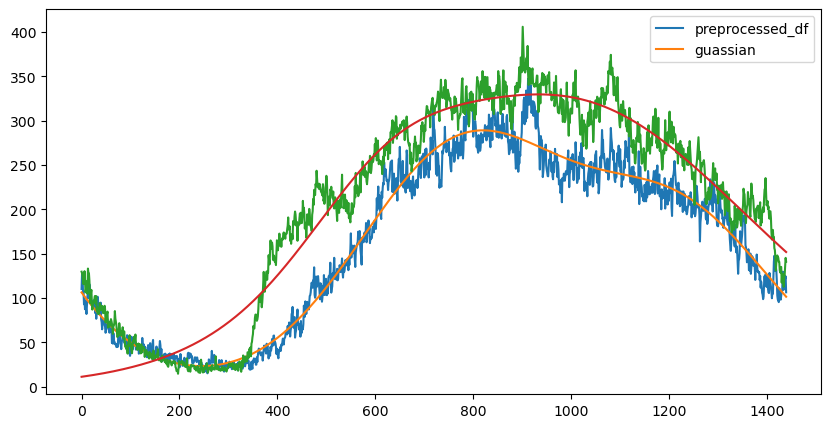

In [14]:
ax = avg_depressed["mean"].plot(figsize=(10,5))
avg_depressed["guassian"].plot(ax=ax)
avg_depressed
ax.legend(["preprocessed_df","guassian"])

ax = avg_non_depressed["mean"].plot(figsize=(10,5))
avg_non_depressed["guassian"].plot(ax=ax)
ax.legend(["preprocessed_df","guassian"])

In [15]:
data = {
    "time":avg_non_depressed["time"].to_list()
}

with open(f"time.json", "w") as outfile:
    json.dump(data, outfile)

## shift data

In [11]:
path = "data/overview/shifted"


def shift_time(df, num):
    shifted_df = pd.DataFrame(columns=['time','activity'])

    shifted_df['activity'] = np.roll(df['activity'],num)
    shifted_df['time'] = np.roll(df['time'],num)
    return shifted_df

def merge_by_type(files, pdf):
    df = files[0][pdf].copy()
    df.rename(columns={"activity": f"{files[0]['name']}"}, inplace=True)
    for i, condition in enumerate(files[1:]):
        df2 = condition[pdf]
        df[f"{condition['name']}"] = condition[pdf]["activity"]
    return df

def avg_by_type(files):
    df = merge_by_type(files, "preprocessed_df_shifted")
    return df

def generate(files):
    for i, condition in enumerate(files):
        df = condition["df"]
        df['date'] = pd.to_datetime(df['timestamp'])
        df['time'] = df['date'].dt.strftime('%H:%M:%S')

        temp = df.sort_values(by=['time'])
        preprocessed_df=get_summary_df(temp)
        condition["preprocessed_df"]=preprocessed_df
        condition["preprocessed_df_shifted"]=shift_time(preprocessed_df, 120)

        condition["guassian"]=get_guassian_df(condition["preprocessed_df"])     
        condition["guassian_shifted"]=get_guassian_df(condition["preprocessed_df_shifted"])
        
generate(nondep_files)
generate(dep_files)
        
avg_non_depressed = avg_by_type(nondep_files)
avg_non_depressed.to_csv(f"{path}/non-depressed_shifted_120.csv")
avg_depressed = avg_by_type(dep_files)
avg_depressed.to_csv(f"{path}/depressed_shifted_120.csv")

In [14]:
import json
data = {
    "time":list(np.roll(avg_non_depressed["time"],240))
}

with open(f"shifted_time.json", "w") as outfile:
    json.dump(data, outfile)

In [12]:
import json
 
def json_output(files, typename):
    data = {
    "type": typename,
    "files": []
    }
    for i in files:
        print(i)
#         a = i["guassian"]["modelPred_activity"].tolist()
#         x = {
#           "file": i["name"],
#           "activity_level": a
#         }
#         data["files"].append(x)
#     with open(f"{path}/{typename}.json", "w") as outfile:
#         json.dump(data, outfile)
#     return True

json_output(nondep_files, "non-depressed")
# json_output(dep_files, "depressed")

{'name': 'control_1', 'df':                  timestamp                date  activity      time
0      2003-03-18 15:00:00 2003-03-18 15:00:00        60  15:00:00
1      2003-03-18 15:01:00 2003-03-18 15:01:00         0  15:01:00
2      2003-03-18 15:02:00 2003-03-18 15:02:00       264  15:02:00
3      2003-03-18 15:03:00 2003-03-18 15:03:00       662  15:03:00
4      2003-03-18 15:04:00 2003-03-18 15:04:00       293  15:04:00
...                    ...                 ...       ...       ...
51606  2003-04-23 12:06:00 2003-04-23 12:06:00         3  12:06:00
51607  2003-04-23 12:07:00 2003-04-23 12:07:00         3  12:07:00
51608  2003-04-23 12:08:00 2003-04-23 12:08:00         3  12:08:00
51609  2003-04-23 12:09:00 2003-04-23 12:09:00         3  12:09:00
51610  2003-04-23 12:10:00 2003-04-23 12:10:00         0  12:10:00

[51611 rows x 4 columns], 'preprocessed_df':           time    activity
0     00:00:00  107.361111
1     00:01:00   97.111111
2     00:02:00   73.138889
3     00:03:00